# Data Science jop salaries: an exploratory analysis

I will conduct an exploratory analysis of a data set taken from <a href="https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries" title="Kaggle"> Kaggle</a> on the data scientist salaries around the world. It includes the so-called data cleaning, data wrangling, data feature engineering and data visualization. 

In [1]:
#Let's load packpages
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib as mat
import matplotlib.pyplot as plt
import country_converter as coco
import scipy.stats as stats 
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
#changing scientific notation pattern
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
#Loading dataset
df = pd.read_csv('ds_salaries.csv')

# 1. Brief description of the data set and a summary of its attributes

## 1.1 Definition of Variables

**Imagem Kaggle**

Let's assume I am preparing the data for a machine learning model, so that we are interested in identifying the predictors of wages in the Data Science field. Hence, salary would be our target variable, but as one can be noted there are two features on salaries. *salary* refers to the salaries in national currency, while *salary_in_usd* refers to salaries converted into US Dolars.

Since data comprise wages across countries, it is suitable in terms of comparison using the variable converted into US currency, according to exchange rates of each country.

## 1.2 General comments on the data

In order to explore general informations about the data set, I use the method `.info()` from the DataFrame class.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


**Main observations**:

* It is not a large data set, containing only 11 columns and 607 observations. 
* Fortunately, there are no missings in any column.
* There is an *Unnamed* feature, like a second index, that should be dropped.
* Most potential predictors, like *job_title* or *employment_type*, are categorical variables, while the target variable is continous. It requires especific ways to check correlations. Traditionally employed, neither scatter plot nor pierson correlation are suitable in this case.  



# 2. Initial plan for data exploration

* Checking distribution of target and feature variable.
* Checking averages for groups.
* Checking outliers in target and features.



## 2.1 Checking distribution of target and feature variable.

Most models depend on how variables are distributed, especially target variable and predictors. Their prediction capability is afected by both non-normalized distributions and outliers, which can lead to biased models. We will check the *salary_in_usd* (target variable) and three features (*job_title*, *company_location* and *experience_level*).

The method `.describe()` provide statistical summary of data, showing informations about their distributions, skew or kurtosis. Let's check our target variable.

### 2.1.1 Target Variable - Salary in USD

In [27]:
#Checking target variable distribution
df['salary_in_usd'].describe()

count      607.000
mean    112297.870
std      70957.259
min       2859.000
25%      62726.000
50%     101570.000
75%     150000.000
max     600000.000
Name: salary_in_usd, dtype: float64

The distribution seems widely spread, since the range between max and min values is high. Also it looks like nearly a normal distribution, given how close mean is to the median (50% percentil). However, the distance between the 75th percentil and the max value is huge, indicating outliers on the top. Let's plot a histogram to see the distribution.

<AxesSubplot:xlabel='salary_in_usd', ylabel='Density'>

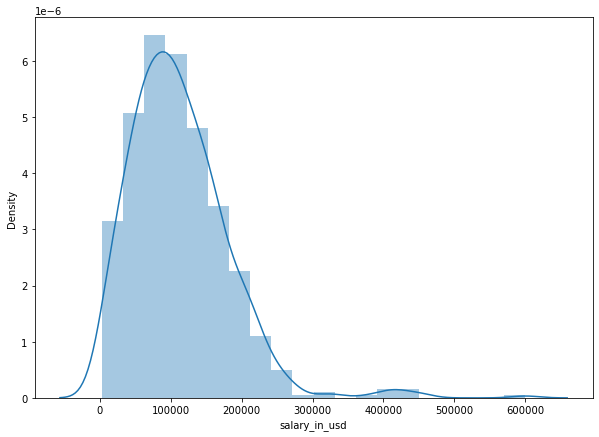

In [10]:
k = plt.figure(figsize = (10,7)) 
sns.distplot(df['salary_in_usd'], bins = 20)

In [46]:
skew = df.salary_in_usd.skew()
norm_skew = 0

if skew == norm_skew:
    print("Since skewness is equal to 0, then it is normally distributed.")
elif skew < norm_skew:
    print("Since skewness is {}, lower than 0, then more weight in the left tail of the distribution.". format(skew))
else:
    print("Since skewness is {}, higher than 0, then more weight in the right tail of the distribution.". format(skew))

Since skewness is 1.667544954563863, higher than 0, then more weight in the right tail of the distribution.


In [47]:
kurtosis = df.salary_in_usd.kurtosis()
norm_kurtosis = 3

if kurtosis == norm_kurtosis:
    print("Since kurtosis is equal to 3, then it is normally distributed.")
elif kurtosis < norm_kurtosis:
    print("Since kurtosis is {},lower than 3, then it is called playkurtic.". format(kurtosis))
else:
    print("Since kurtosis is {}, higher than 3, it is called leptokurtic and it signifies that it tries to produce more outliers rather than the normal distribution.". format(kurtosis))

Since kurtosis is 6.353794741063377, higher than 3, it is called leptokurtic and it signifies that it tries to produce more outliers rather than the normal distribution.


So, as we can see, it seems that target variable needs to be transformed. 

### 2.1.2 Feature 1 - Company level

Let's look at the sample size in each country, in onder to check whether their average salaries are really comparable. As we can see below, there is an overrepresentation of interviewed people from United States, which accounts for almost 60% of the respondents, no other country accounts for even 10%. In this case, I think that a predictive model should focus on United States, since it is about that country about which data can provide reliable predictions.

In [49]:
df['company_location'].value_counts(normalize = True)

US   0.585
GB   0.077
CA   0.049
DE   0.046
IN   0.040
FR   0.025
ES   0.023
GR   0.018
JP   0.010
NL   0.007
AT   0.007
PT   0.007
PL   0.007
LU   0.005
PK   0.005
BR   0.005
AE   0.005
MX   0.005
AU   0.005
TR   0.005
DK   0.005
IT   0.003
CZ   0.003
SI   0.003
RU   0.003
CH   0.003
NG   0.003
CN   0.003
BE   0.003
VN   0.002
EE   0.002
AS   0.002
DZ   0.002
MY   0.002
MD   0.002
KE   0.002
SG   0.002
CO   0.002
IR   0.002
CL   0.002
MT   0.002
IL   0.002
UA   0.002
IQ   0.002
RO   0.002
HR   0.002
NZ   0.002
HU   0.002
HN   0.002
IE   0.002
Name: company_location, dtype: float64

### 2.1.3 Feature 2 - Experience level

Regarding american interviewed, senior data scientists were more interviewed, which is reasonable, because is neither a begineer nor an leader position. Also, as expected, the highest average salary is for Executive (EX).

In [72]:
df1 = df[df['company_location'] == "US"] #slicing data by US sample
df1[['experience_level']].value_counts() #frequency for experience level

experience_level
SE                  218
MI                   90
EN                   31
EX                   16
dtype: int64

In [76]:
df1.groupby('experience_level').salary_in_usd.mean().sort_values(ascending = False) #average salary by experience level

experience_level
EX   243742.188
SE   151527.633
MI   125780.211
EN    93112.903
Name: salary_in_usd, dtype: float64

### 2.1.4 Job Title

Data Science is a broad field with several functions among which the average salary might vary. As can be seen below, there is a lot of categories, so that it would be useful join some of them, especially those one with a few observations.

In [80]:
df1['job_title'].value_counts()

Data Engineer                               85
Data Scientist                              84
Data Analyst                                71
Machine Learning Engineer                   16
Data Science Manager                        10
Data Architect                               9
Data Analytics Manager                       7
BI Data Analyst                              5
Machine Learning Scientist                   5
Analytics Engineer                           4
Principal Data Scientist                     4
AI Scientist                                 4
Research Scientist                           4
Head of Data Science                         3
Lead Data Engineer                           3
Data Engineering Manager                     3
Applied Data Scientist                       3
Applied Machine Learning Scientist           3
Principal Data Engineer                      3
Computer Vision Software Engineer            2
Financial Data Analyst                       2
Head of Data 

## 2.2 Outliers

Outliers can produce biased models, that is why we have to pay attention them. The target variable is a continous variable. 

<AxesSubplot:xlabel='salary_in_usd'>

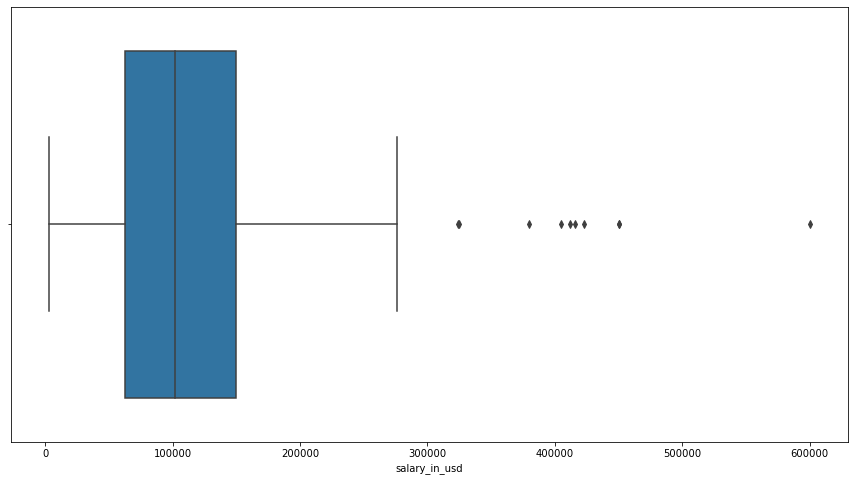

In [95]:
sns.boxplot(x = df['salary_in_usd'])

As suggested earlier, there is a couple of outliers. Also outliers skew the distribution to the left. This indicates that some measures must be made to normalize distribution. 

# 3 Actions taken for data cleaning and feature engineering

* Handling outliers in the target variable
* Transform categories within experience_level, job_type and company_location
* Create a numeric id for company location

# 3.1 Target Variable

Let's check if log transformation solves normal distribution and outliers in target variable.

Text(0.5, 0.98, 'Salary in USD')

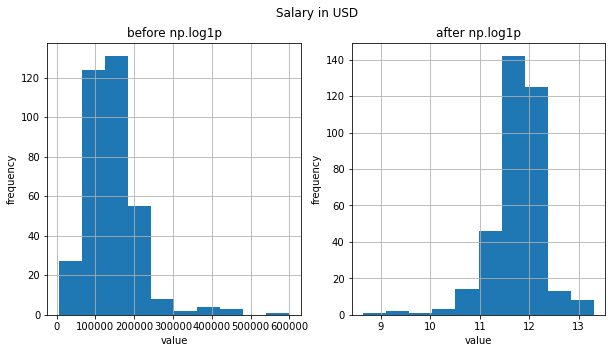

In [81]:
# Let's look at what happens to one of these features, when we apply np.log1p visually.

# Choose a field
# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
df1['salary_in_usd'].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
df1['salary_in_usd'].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Salary in USD')

In [100]:
print(np.log(df1['salary_in_usd'].skew()),np.log(df1['salary_in_usd'].kurtosis()))

0.7042816277796355 2.113709158175574


Now we have skewness and kurtosis closer than a normal distribution, but below we note that ouliers remain.

<AxesSubplot:xlabel='salary_in_usd'>

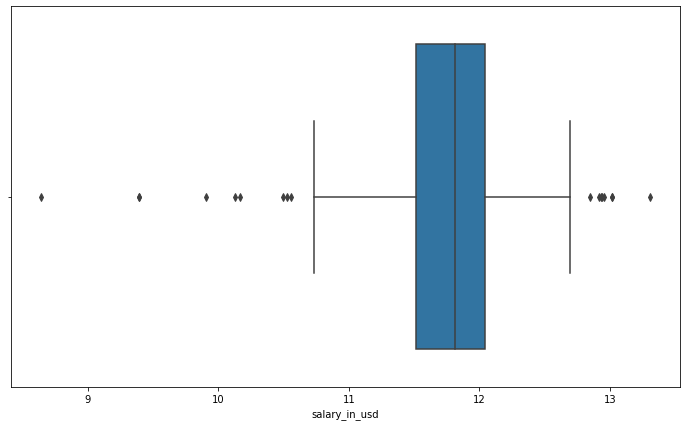

In [84]:
plt.figure(figsize= (12,7)) 
sns.boxplot(x = np.log(df1['salary_in_usd']))
#However, now we have outliers at the bottom.

In [103]:
df1['stats_salary'] = stats.zscore(np.log(df1['salary_in_usd']))
df1[['stats_salary', 'salary_in_usd']].describe().round(3)

,stats_salary,salary_in_usd
count,355.000,355.000
mean,0.000,144055.262
std,1.001,69906.895
min,-6.066,5679.000
25%,-0.488,100000.000
50%,0.095,135000.000
75%,0.544,170000.000
max,2.996,600000.000


I use the z-score technique to check normalization and outliers after log transformation. The Z-core mean of stats_salary is 0, which shows that distribution was normalized. There are a few values that keep slightly below of the limit, then I think that the best choice is not drop any value. 

In [107]:
df1[['stats_salary', 'salary_in_usd', 'experience_level']].sort_values(by = 'salary_in_usd')[:10] 

,stats_salary,salary_in_usd,experience_level
179,-6.066,5679,MI
113,-4.611,12000,EN
96,-4.611,12000,EN
208,-3.618,20000,MI
579,-3.184,25000,SE
182,-3.107,26005,MI
102,-2.461,36259,MI
455,-2.409,37236,MI
132,-2.349,38400,MI
40,-2.008,45760,MI


## 3.2 Transforming categorical variables

I will merge categories of job_title, since there are many categories that resembles each other and other with very few observations. Let's merge variations of 'Data scientists', 'Data Analyst', 'Data Engineer' into the main categories. 

In [108]:
df1.job_title.value_counts()

Data Engineer                               85
Data Scientist                              84
Data Analyst                                71
Machine Learning Engineer                   16
Data Science Manager                        10
Data Architect                               9
Data Analytics Manager                       7
BI Data Analyst                              5
Machine Learning Scientist                   5
Analytics Engineer                           4
Principal Data Scientist                     4
AI Scientist                                 4
Research Scientist                           4
Head of Data Science                         3
Lead Data Engineer                           3
Data Engineering Manager                     3
Applied Data Scientist                       3
Applied Machine Learning Scientist           3
Principal Data Engineer                      3
Computer Vision Software Engineer            2
Financial Data Analyst                       2
Head of Data 

In [109]:
data = df1.copy() #making a backup

#aggregating different categories for Data Science
df1['job_title'] = np.where((df1['job_title'] == 'Data Science Manager') | (df1['job_title'] == 'Applied Data Scientist') | (df1['job_title'] == 'Head of Data Science') |
                            (df1['job_title'] =='Staff Data Scientist') | (df1['job_title'] == 'Data Science Consultant') |  (df1['job_title'] == 'Principal Data Scientist')|
                             (df1['job_title'] == 'Lead Data Scientist') | (df1['job_title'] == 'Director of Data Science'), 'Data Scientist', df1['job_title'])

In [110]:
#aggregating different categories for Data Engineer
df1['job_title'] = np.where((df1['job_title'] == 'Machine Learning Engineer') | (df1['job_title'] == 'Big Data Engineer') | (df1['job_title'] == 'Lead Data Engineer') |
                            (df1['job_title'] =='Principal Data Engineer') | (df1['job_title'] == 'Director of Data Engineering') | (df1['job_title'] == 'Cloud Data Engineer')|
                            (df1['job_title'] == 'Director of Data Engineering') | (df1['job_title'] == 'Lead Machine Learning Engineer') | (df1['job_title'] == 'NLP Engineer') |
                            (df1['job_title'] == 'Machine Learning Infrastructure Engineer') | (df1['job_title'] == 'ML Engineer'), 'Data Engineer', df1['job_title'])

In [111]:
#aggregating different categories for Data Analytics
df1['job_title'] = np.where((df1['job_title'] == 'Data Analytics Manager') | (df1['job_title'] == 'Big Data Analyst') | (df1['job_title'] == 'Business Data Analyst') |
                            (df1['job_title'] =='Lead Data Analyst') | (df1['job_title'] == 'Product Data Analyst') | (df1['job_title'] == 'Financial Data Analyst')|
                            (df1['job_title'] == 'Principal Data Analyst') | (df1['job_title'] == 'Finance Data Analyst') | (df1['job_title'] == 'Marketing Data Analyst') |
                            (df1['job_title'] == 'Data Analytics Lead') | (df1['job_title'] == 'BI Data Analyst'), 'Data Analyst', df1['job_title'])

In [112]:
#aggregating different categories for Architect
df1['job_title'] = np.where((df1['job_title'] == 'Big Data Architect'), 'Data Architect', df1['job_title'])

In [113]:
#aggregating different categories for Machine Learning Scientist
df1['job_title'] = np.where((df1['job_title'] == 'Applied Machine Learning Scientist') | (df1['job_title'] == 'Machine Learning Manager') |
                            (df1['job_title'] == 'Machine Learning Developer') | (df1['job_title'] == 'Head of Machine Learning'),
                             'Machine Learning Scientist', df1['job_title'])

In [114]:
df1.job_title.value_counts()

Data Engineer                        114
Data Scientist                       110
Data Analyst                          91
Data Architect                         9
Machine Learning Scientist             8
Research Scientist                     4
AI Scientist                           4
Analytics Engineer                     4
Data Engineering Manager               3
Computer Vision Engineer               2
Head of Data                           2
Computer Vision Software Engineer      2
Data Analytics Engineer                1
Data Specialist                        1
Name: job_title, dtype: int64

In [115]:
counts_job = df1.job_title.value_counts() #extracting value counts of the attribute job_title
counts_job

Data Engineer                        114
Data Scientist                       110
Data Analyst                          91
Data Architect                         9
Machine Learning Scientist             8
Research Scientist                     4
AI Scientist                           4
Analytics Engineer                     4
Data Engineering Manager               3
Computer Vision Engineer               2
Head of Data                           2
Computer Vision Software Engineer      2
Data Analytics Engineer                1
Data Specialist                        1
Name: job_title, dtype: int64

In [127]:
other_job = list(counts_job[counts_job <= 7].index) #filtering by values counts below 4

In [128]:
df2 = df1.copy() #making a backup
df2['job_title'] = df2['job_title'].replace(other_job, 'Other') #replacing by merge categories
df2['job_title'].value_counts() #it has remained these categories within job_title 

Data Engineer                 114
Data Scientist                110
Data Analyst                   91
Other                          23
Data Architect                  9
Machine Learning Scientist      8
Name: job_title, dtype: int64

Here we replace the variable job title by the new one with grouped categories.  Now we can plot to better analyse the relation between job title and wages. Let's calculate average salary for each job title.

In [130]:
order = df2.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending = False).index

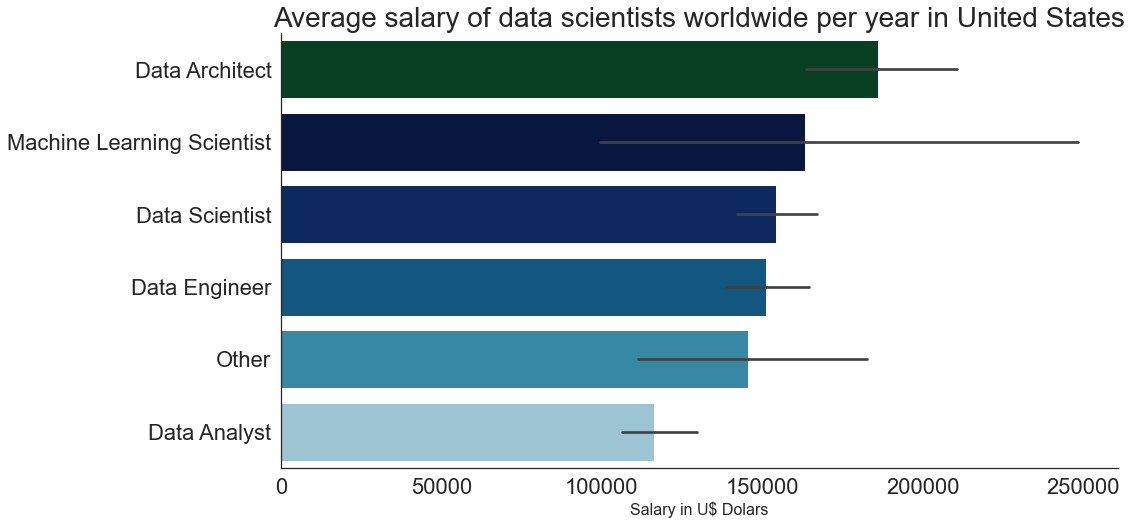

In [132]:
z =plt.figure(figsize=(15,8))
sns.set_style("white")
sns.barplot(x = 'salary_in_usd', y = 'job_title', orient = 'h', palette = 'ocean', order = order, data = df2)
sns.despine(top=True, right=True, left=False, bottom=False)
sns.set(font_scale=2)
plt.title('Average salary of data scientists worldwide per year in United States', fontsize = 28)
plt.xlabel('Salary in U$ Dolars', fontsize = 16)
plt.ylabel('')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [214]:
z.savefig("wage_ds1.png", bbox_inches='tight')

As can be seen, the graph shows the confidence interval for each category, since the number of observations among cases varies.  For instance, Data Architect has the highest wage, but there are just 9 observations, while Data Engineer has 114. In such case, it is useful calculate a weighted average.

In [133]:
pond = df2.job_title.value_counts(normalize = True) *10 #As a weight, I am going to use observations frequency for each job title
som = df2.groupby('job_title')['salary_in_usd'].sum() #sum 
df3 = df2.rename(columns = {'job_title': 'new'}) #renaming for conconate foward
n = df3['new'].value_counts() #extracting total n

In [134]:
con = pd.concat([pond, som, n], axis = 1) #joining those values into a new dataframe
con = pd.DataFrame(con)
con

,job_title,salary_in_usd,new
Data Engineer,3.211,17246726,114
Data Scientist,3.099,16975869,110
Data Analyst,2.563,10591064,91
Other,0.648,3345746,23
Data Architect,0.254,1673513,9
Machine Learning Scientist,0.225,1306700,8


In [135]:
con['weight'] = (con['salary_in_usd']*con['job_title'])/con['new'] #calculating mean weighted
con.sort_values('weight', ascending = False)

,job_title,salary_in_usd,new,weight
Data Engineer,3.211,17246726,114,485823.268
Data Scientist,3.099,16975869,110,478193.493
Data Analyst,2.563,10591064,91,298339.831
Other,0.648,3345746,23,94246.366
Data Architect,0.254,1673513,9,47141.211
Machine Learning Scientist,0.225,1306700,8,36808.451


In [136]:
con = con.reset_index()
con

,index,job_title,salary_in_usd,new,weight
0,Data Engineer,3.211,17246726,114,485823.268
1,Data Scientist,3.099,16975869,110,478193.493
2,Data Analyst,2.563,10591064,91,298339.831
3,Other,0.648,3345746,23,94246.366
4,Data Architect,0.254,1673513,9,47141.211
5,Machine Learning Scientist,0.225,1306700,8,36808.451


In [137]:
#creating the order of value for ploting forward
order2 = con.sort_values(by = ['weight'], ascending = False).set_index('index').round(0).index

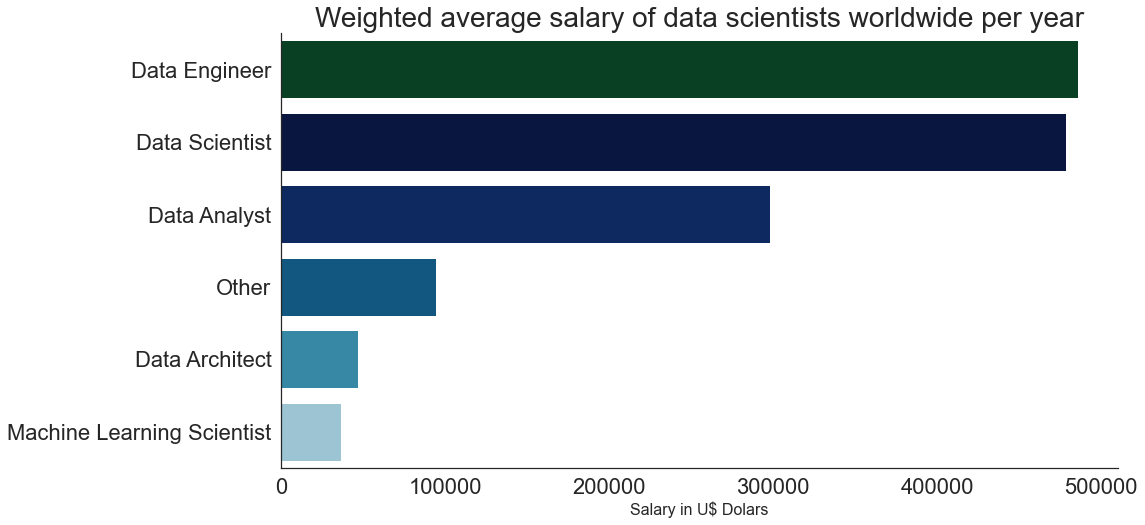

In [138]:
#plotting average wages by job title
g =plt.figure(figsize=(15,8))

sns.set_style("white")
sns.barplot(x = 'weight', y = 'index', orient = 'h', palette = 'ocean', order = order2, data = con)
sns.despine(top=True, right=True, left=False, bottom=False)
sns.set(font_scale=2)
plt.title('Weighted average salary of data scientists in United States per year', fontsize = 28)
plt.xlabel('Salary in U$ Dolars', fontsize = 16)
plt.ylabel('')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [149]:
g.savefig("wage_ds.png", bbox_inches='tight') #saving chart

Now we can see that Data Architect has one of the lowest average salary, while Data Engineer has highest salary now.

# 4. Looking beyond the United States

I have already analyzed that Data engineer has the highest weighted average salary, followed by Data Scientist and Data Analyst in United States. However there are another features that should be checked, such as the location company. Let's check the variation among countries. 

In [140]:
df['company_location'].value_counts()

US    355
GB     47
CA     30
DE     28
IN     24
FR     15
ES     14
GR     11
JP      6
NL      4
AT      4
PT      4
PL      4
LU      3
PK      3
BR      3
AE      3
MX      3
AU      3
TR      3
DK      3
IT      2
CZ      2
SI      2
RU      2
CH      2
NG      2
CN      2
BE      2
VN      1
EE      1
AS      1
DZ      1
MY      1
MD      1
KE      1
SG      1
CO      1
IR      1
CL      1
MT      1
IL      1
UA      1
IQ      1
RO      1
HR      1
NZ      1
HU      1
HN      1
IE      1
Name: company_location, dtype: int64

We will only take into account countries with more than 10 observations and drop the United States, due to its sample overrepresentation. 

In [144]:
countries = df[df['company_location'].isin(['GB', 'CA', 'DE', 'IN', 'FR', 'FR', 'ES', 'GR'])] #slicing cases with more than 10 observations
countries['country_names'] = coco.convert(names= countries['company_location'], to='name_short') #ISO2 for country names
countries.groupby('country_names')['salary_in_usd'].mean().sort_values(ascending = False)

country_names
Canada           99823.733
Germany          81887.214
United Kingdom   81583.043
France           63970.667
Spain            53060.143
Greece           52293.091
India            28581.750
Name: salary_in_usd, dtype: float64

The highest average salary is in United States, with a huge difference compared to Canada. Let's check whether the remuneration between the different job titles varies among countries.

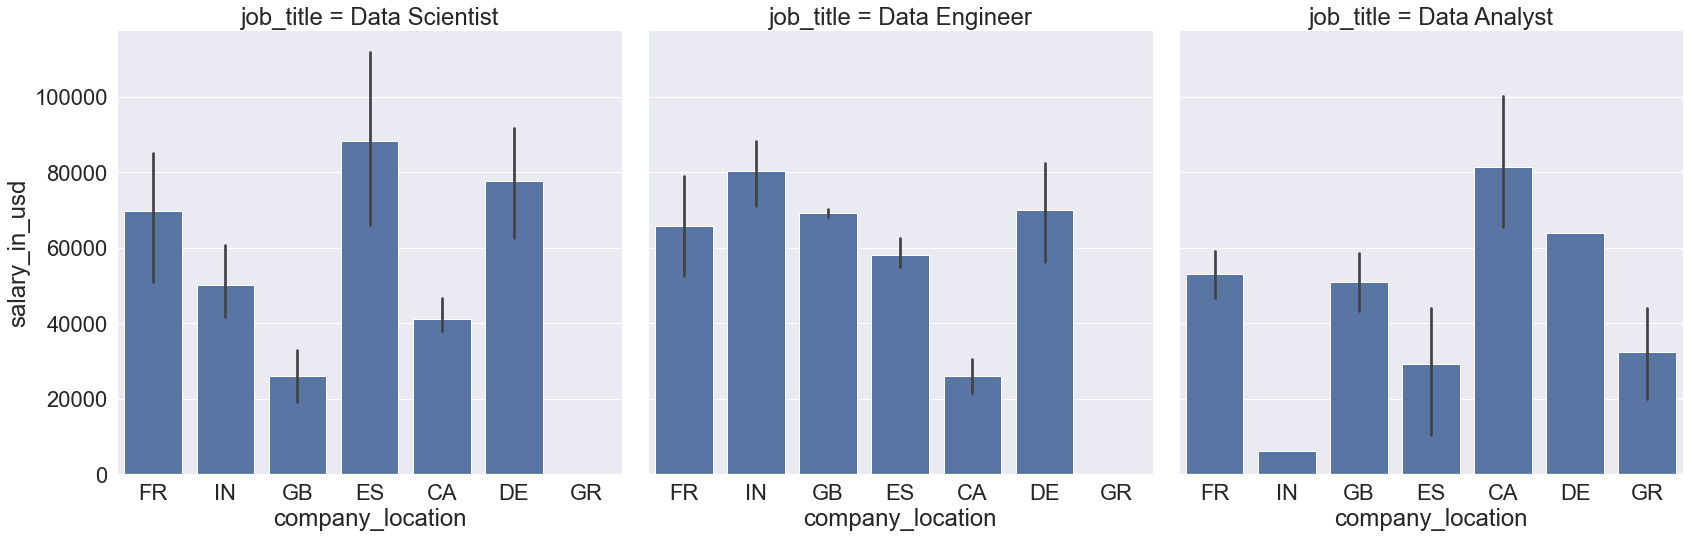

In [145]:
countries2 = countries[countries['job_title'].isin(['Data Scientist', 'Data Analyst', 'Data Engineer'])]
c = sns.FacetGrid(countries2, col="job_title", height=8)
c.map(sns.barplot, "company_location", "salary_in_usd")

There is no pattern among countries. In some places, Data Analyst earn more than Data Engineer and Data Scientist (Canadá); others Data Scientist has the highest average wage (Spain) and finally there are those in which Data Engineer has the highest average wage (Great Britain). 

# 5. Formulating at least 3 hypothesis test about this data.

* Hypothesis 1 - Differences between Data Scientist and Data Analyst average salaries are random
* Hypothesis 2 - Differences of average salaries for companyies with different sizes are random
* Hypothesis 3 - Differences in salary variance between data scientists and data analysts is random

I will focus on the first hypothesis. Data show (see chart above) that Data Analyst average wage is higher than Data Scientist in US. We will test if this difference is statistical significant. Let 𝜇1 be the average salary for Data Analyst and 𝜇2 be the average salary for Data Scientist. We will compare these mean values, $\mu\_{1}$ and $\mu\_{2}$, statistically at 5% of significance.  

Null hypothesis presumes that the difference observed between averages is random. Alternative hypothesis assumes that it is systematic.

$ 𝐻\_{0}:\mu\_{1}-\mu\_{2} = 0 $ There is no difference between Data Analyst and Data Scientist average salaries. \
$ 𝐻\_{A}:\mu\_{1}-\mu\_{2} != 0 $ There is difference between Data Analyst and Data Scientist average salaries.

Evaluate and interpret the result


In [146]:
da = df[(df['job_title'] == 'Data Analyst') & (df['company_location'] == 'US')][['salary_in_usd']] #data analyst
ds = df[(df['job_title'] == 'Data Scientist') & (df['company_location'] == 'US')][['salary_in_usd']] #data scientist

In [147]:
s_da = da.salary_in_usd
s_ds = ds.salary_in_usd

<AxesSubplot:xlabel='salary_in_usd', ylabel='Density'>

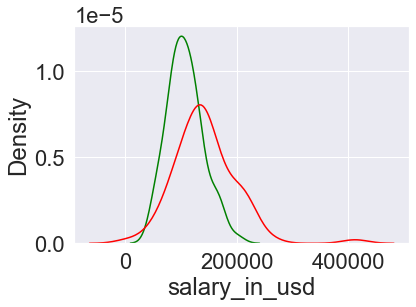

In [148]:
sns.distplot(s_da,color='green',hist=False)
sns.distplot(s_ds,color='red',hist=False)

From graphic, we see that the distributions are different. Let's apply test T, which is aimed at testing averages between two groups.

In [346]:
#Applying test t for comparing the two averages
alpha=0.05
t_value1, p_value1 = stats.ttest_ind(s_da, s_ds)
print("t_value1 = ",t_value1, ", p_value1 = ", (format(p_value1, '.65f')))

t_value1 =  -4.277374565975957 , p_value1 =  0.00002934917419430394625945793252164150999306002631783485412597656


In [339]:
if p_value1 <alpha:
    print("Conclusion: since p_value {} is less than alpha {} ". format (p_value1,alpha))
    print("Reject the null hypothesis that there is no difference between Data Analyst and Data Scientist")
    
else:
    print("Conclusion: since p_value {} is greater than alpha {} ". format (p_value1,alpha))
    print("Fail to reject the null hypothesis that there is a difference between Data Anaçyst and Data Scientist.")

Conclusion: since p_value 2.9349174194303946e-05 is less than alpha 0.05 
Reject the null hypothesis that there is no difference between Data Analyst and Data Scientist


The Test T indicates that the difference observed between Data Analyst and Data Scientist average salaries is not random in United States. 

## Suggestions for next steps in analyzing this Data

The main suggestion is analyzing average salaries weighted by experience level and employment type, which can affect the results. For exemple, if most of the data scientists interviewed are at the junior level, the average salaries will be skewed downward. 

## A paragraph that summarizes the quality of this data set and a request for additional data if needed

The quality of this data set is very good, without typos and missings. Also there is a lot of detailed information. However, there is an overrepresentation of data from United States, so it is necessary gather more data from another countries in order to set comparative analyses more reliable. 